## 1. Load the expression data and matching metadata from Assignment 2.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mygene

# Load gene expression and metadata into dataframes
expr = pd.read_csv("../data/SRP075806/SRP075806.tsv", sep='\t')
meta = pd.read_csv("../data/SRP075806/metadata_SRP075806.tsv", sep='\t')

# Query mygene for gene names
expr = expr.set_index("Gene")
mg = mygene.MyGeneInfo()
print('Querying...')
res = mg.querymany(expr.index.tolist(), scopes="ensembl.gene", fields="symbol", species="human")

# Mapping dataframe
mapping = (pd.DataFrame(res).loc[:, ["query", "symbol"]].dropna()
             .rename(columns={"query": "Ensembl", "symbol": "GeneName"}))

# Use mapping dataframe to build expression matrix
expr = expr.merge(mapping, left_index=True, right_on="Ensembl")
expr = expr.drop(columns="Ensembl").set_index("GeneName")

# If multiple Ensembl IDs map to the same symbol, combine the rows
expr = expr.groupby(expr.index).mean()

print("Expr.shape (with gene names):", expr.shape, '\n')

expr_log = np.log2(expr+1)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Querying...


27 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('E
1224 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000131484', 'ENS


Expr.shape (with gene names): (32059, 116) 



## 2. Unsupervised Analysis 

--------------------------------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.base import clone

# Step 1: Compute variance and select top genes
gene_variances = expr_log.var(axis=1)
gene_variances_sorted = gene_variances.sort_values(ascending=False)

subset_sizes = [10, 100, 1000, 5000, 10000]
gene_subsets = {}

for n in subset_sizes:
    top_genes = gene_variances_sorted.head(n).index
    subset = expr_log.loc[top_genes]
    subset_T = subset.T
    scaler = StandardScaler()
    subset_scaled = scaler.fit_transform(subset_T)
    gene_subsets[n] = pd.DataFrame(subset_scaled, index=subset_T.index, columns=subset_T.columns)
    print(f"Top {n} most variable genes subset:", subset_scaled.shape)

# Step 2: Helper function
def compare_membership_across_k(method, X, k_values):
    """Compare cluster membership similarity across k values for one method."""
    results = {}
    for k in k_values:
        model = clone(method).set_params(n_clusters=k)
        labels = model.fit_predict(X)
        results[k] = labels

    comparison = []
    for (k1, labels1), (k2, labels2) in itertools.combinations(results.items(), 2):
        ari = adjusted_rand_score(labels1, labels2)
        nmi = normalized_mutual_info_score(labels1, labels2)
        comparison.append({"k1": k1, "k2": k2, "ARI": ari, "NMI": nmi})
    return pd.DataFrame(comparison), results

# Use top 5000 genes
X_scaled = gene_subsets[5000].values
k_values = [2, 3, 5, 8, 10]
print("\nUsing top 5000 genes for clustering analysis.")
print("Data shape:", X_scaled.shape)


Top 10 most variable genes subset: (116, 10)
Top 100 most variable genes subset: (116, 100)
Top 1000 most variable genes subset: (116, 1000)
Top 5000 most variable genes subset: (116, 5000)
Top 10000 most variable genes subset: (116, 10000)

Using top 5000 genes for clustering analysis.
Data shape: (116, 5000)



K-Means: Cluster membership similarity across k values:
   k1  k2       ARI       NMI
0   2   3  0.435292  0.605582
1   2   5  0.255768  0.455562
2   2   8  0.092715  0.318736
3   2  10  0.084745  0.299582
4   3   5  0.690331  0.808957
5   3   8  0.297494  0.607758
6   3  10  0.274452  0.577198
7   5   8  0.388734  0.677723
8   5  10  0.353417  0.647733
9   8  10  0.953005  0.963364


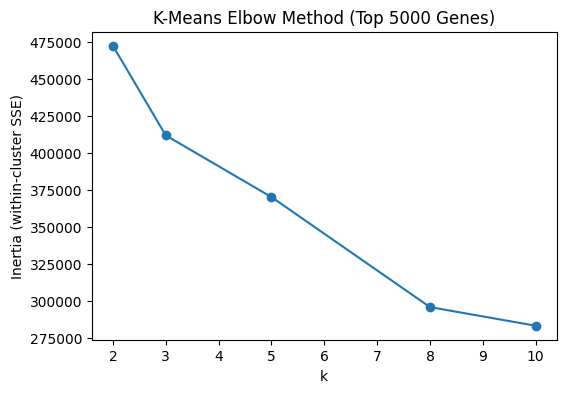

In [3]:
from sklearn.cluster import KMeans

df_kmeans, kmeans_labels = compare_membership_across_k(
    KMeans(random_state=42),
    X_scaled,
    k_values
)

print("\nK-Means: Cluster membership similarity across k values:")
print(df_kmeans)

# Elbow method
inertias = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias[k] = kmeans.inertia_

plt.figure(figsize=(6, 4))
plt.plot(list(inertias.keys()), list(inertias.values()), marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("K-Means Elbow Method (Top 5000 Genes)")
plt.show()


k=2: 2 clusters found
k=3: 3 clusters found
k=5: 5 clusters found
k=8: 8 clusters found
k=10: 10 clusters found

GMM: Cluster membership similarity across k values:
   k1  k2       ARI       NMI
0   2   3  0.435292  0.605582
1   2   5  0.255768  0.455562
2   2   8  0.092715  0.318736
3   2  10  0.084745  0.299582
4   3   5  0.690331  0.808957
5   3   8  0.297494  0.607758
6   3  10  0.274452  0.577198
7   5   8  0.388734  0.677723
8   5  10  0.353417  0.647733
9   8  10  0.953005  0.963364


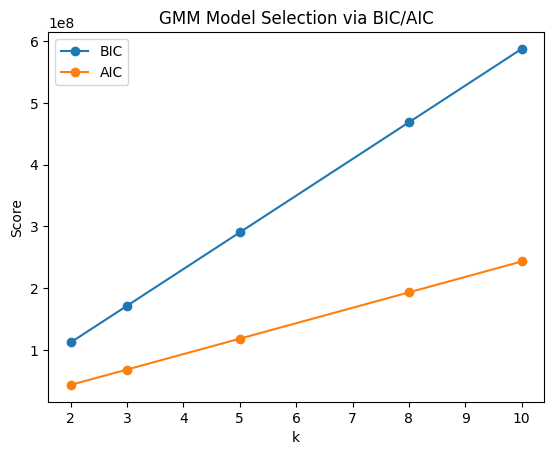

In [4]:
from sklearn.mixture import GaussianMixture

bics, aics = {}, {}
gmm_labels = {}

for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bics[k] = gmm.bic(X_scaled)
    aics[k] = gmm.aic(X_scaled)
    gmm_labels[k] = gmm.predict(X_scaled)
    print(f"k={k}: {len(np.unique(gmm_labels[k]))} clusters found")

# Membership comparison
comparison_gmm = []
for (k1, l1), (k2, l2) in itertools.combinations(gmm_labels.items(), 2):
    ari = adjusted_rand_score(l1, l2)
    nmi = normalized_mutual_info_score(l1, l2)
    comparison_gmm.append({"k1": k1, "k2": k2, "ARI": ari, "NMI": nmi})
df_gmm = pd.DataFrame(comparison_gmm)

print("\nGMM: Cluster membership similarity across k values:")
print(df_gmm)

# Plot BIC/AIC
plt.plot(list(bics.keys()), list(bics.values()), label="BIC", marker='o')
plt.plot(list(aics.keys()), list(aics.values()), label="AIC", marker='o')
plt.xlabel("k")
plt.ylabel("Score")
plt.legend()
plt.title("GMM Model Selection via BIC/AIC")
plt.show()


In [ ]:
# Implement PAM using sklearn-extra


k=2: 2 clusters found
k=3: 3 clusters found
k=5: 5 clusters found
k=8: 8 clusters found
k=10: 10 clusters found

Agglomerative: Cluster membership similarity across k values:
   k1  k2       ARI       NMI
0   2   3  0.303670  0.547487
1   2   5  0.131456  0.378575
2   2   8  0.079814  0.308764
3   2  10  0.064403  0.284939
4   3   5  0.564244  0.765008
5   3   8  0.376876  0.652618
6   3  10  0.313468  0.611860
7   5   8  0.742794  0.877620
8   5  10  0.642178  0.831481
9   8  10  0.889185  0.952890


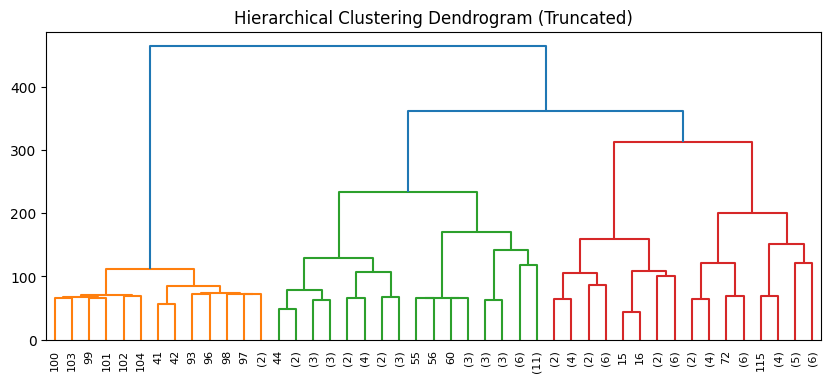

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

agg_labels = {}

for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_scaled)
    agg_labels[k] = labels
    print(f"k={k}: {len(np.unique(labels))} clusters found")

# Membership comparison
comparison_agg = []
for (k1, l1), (k2, l2) in itertools.combinations(agg_labels.items(), 2):
    ari = adjusted_rand_score(l1, l2)
    nmi = normalized_mutual_info_score(l1, l2)
    comparison_agg.append({"k1": k1, "k2": k2, "ARI": ari, "NMI": nmi})
df_agg = pd.DataFrame(comparison_agg)

print("\nAgglomerative: Cluster membership similarity across k values:")
print(df_agg)

# Dendrogram
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 4))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.show()


In [6]:
from sklearn.cluster import SpectralClustering

spectral_labels = {}
for k in k_values:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(X_scaled)
    spectral_labels[k] = labels
    print(f"k={k}: {len(np.unique(labels))} clusters found")

# Membership comparison
comparison_spectral = []
for (k1, l1), (k2, l2) in itertools.combinations(spectral_labels.items(), 2):
    ari = adjusted_rand_score(l1, l2)
    nmi = normalized_mutual_info_score(l1, l2)
    comparison_spectral.append({"k1": k1, "k2": k2, "ARI": ari, "NMI": nmi})
df_spectral = pd.DataFrame(comparison_spectral)

print("\nSpectral: Cluster membership similarity across k values:")
print(df_spectral)


d:\projects\cgs4144_project\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\projects\cgs4144_project\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=2: 2 clusters found
k=3: 3 clusters found


d:\projects\cgs4144_project\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\projects\cgs4144_project\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\projects\cgs4144_project\.venv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


k=5: 5 clusters found
k=8: 8 clusters found
k=10: 10 clusters found

Spectral: Cluster membership similarity across k values:
   k1  k2       ARI       NMI
0   2   3  0.582235  0.676847
1   2   5  0.170599  0.400901
2   2   8  0.079814  0.308764
3   2  10  0.064403  0.284939
4   3   5  0.370110  0.657806
5   3   8  0.183824  0.526048
6   3  10  0.149896  0.490318
7   5   8  0.616616  0.842737
8   5  10  0.525941  0.797130
9   8  10  0.889185  0.952890


In [7]:
from sklearn.cluster import AffinityPropagation

# Affinity Propagation does not use predefined k
affprop = AffinityPropagation(random_state=42)
clusters = affprop.fit_predict(X_scaled)
print(f"Affinity Propagation found {len(np.unique(clusters))} clusters")

# Explore effect of preference parameter
for pref in [-50, -10, 0, 10]:
    affprop = AffinityPropagation(preference=pref, random_state=42)
    clusters = affprop.fit_predict(X_scaled)
    print(f"preference={pref}: {len(np.unique(clusters))} clusters found")


Affinity Propagation found 14 clusters
preference=-50: 116 clusters found
preference=-10: 116 clusters found
preference=0: 116 clusters found
preference=10: 116 clusters found


---------------------------------------------------------------------------------------------------

## 3. Heatmaps and Dendrograms 

## 4. Statistics

## 5. Write a short summary for each plot/table. In 3-5 sentences for each, describe what you did, what parameters you used (if any) and an interesting result from it.

## 6. Combine all results into a single file and submit on Canvas. Make sure that all your code and results are added to the GitHub repository. 